<a href="https://colab.research.google.com/github/AndresSepulveda/PHP_LucasC/blob/main/PHP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Para conectarnos a la nube 
# ==============================================================================
from google. colab import drive 
drive.mount('/content/gdrive',force_remount=True)

# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, DateFormatter
from matplotlib import style
import seaborn as sns
import datetime
from datetime import datetime, timedelta

# Utilidades
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

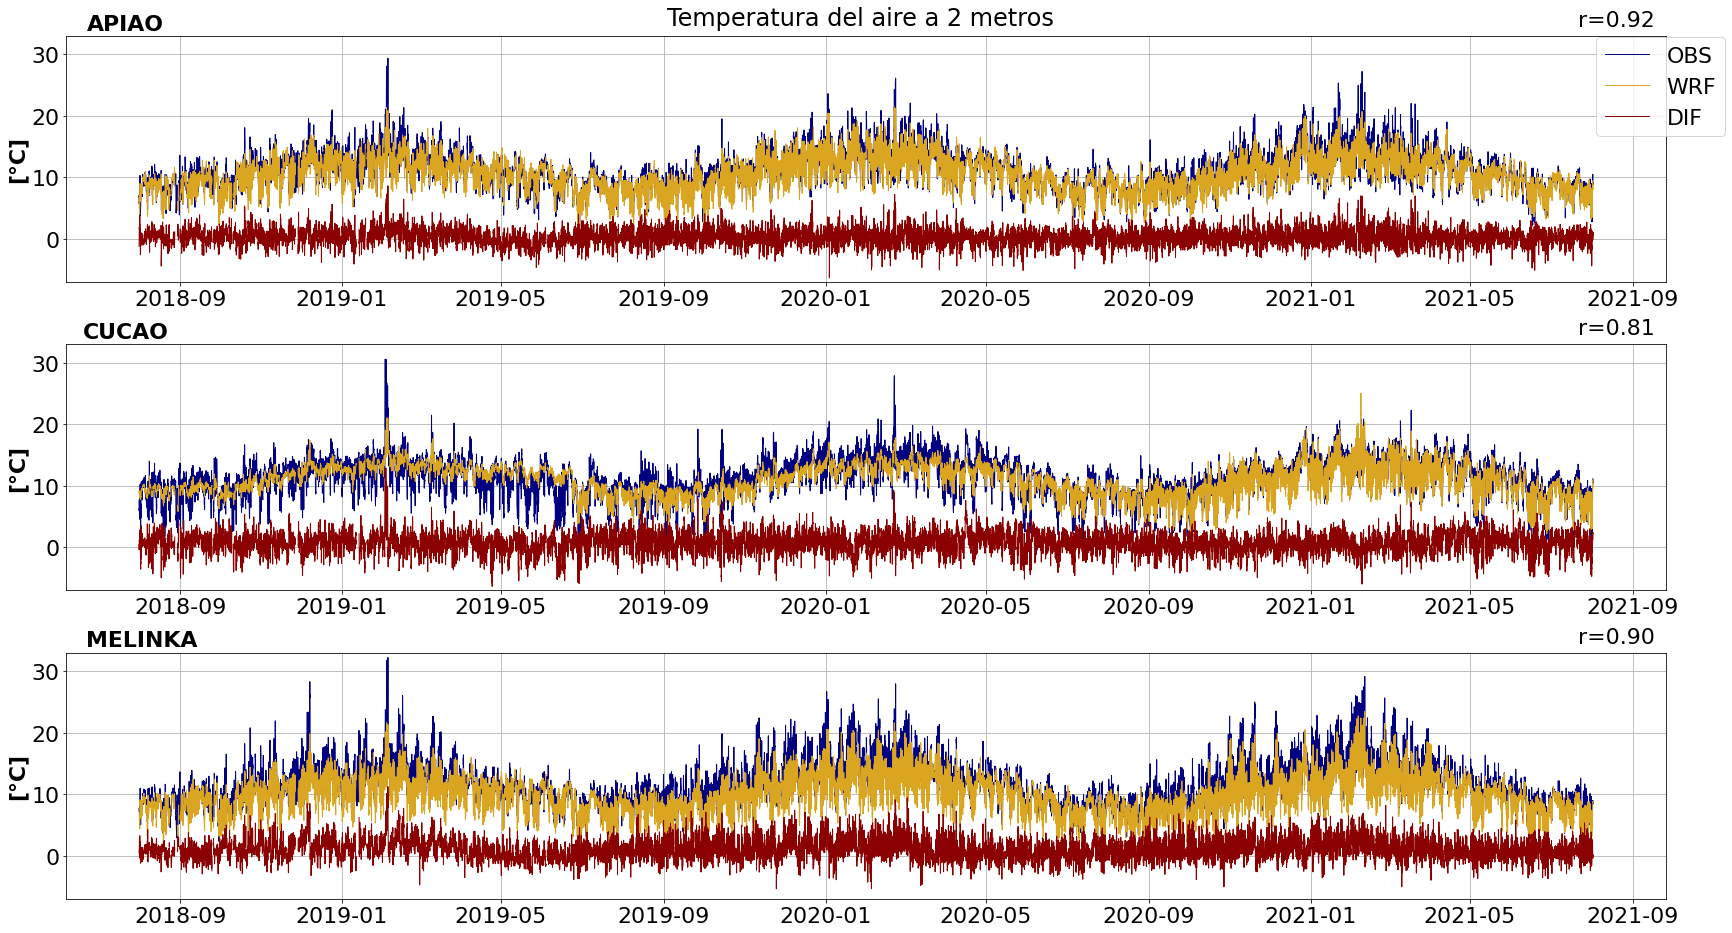

In [3]:
# Cargamos los datos horarios (considerando desde el 1 de Agosto de 2018 00:00:00 hasta el 1 de Agosto de 2021 23:00:00)
# T2 es la temperatura observada y T2_WRF es la temperatura simulada
APIAO = pd.read_excel('/content/gdrive/MyDrive/Colab/PHP/data/APIAO_T2.xlsx') 
APIAO.set_index('Time', inplace=True) # para dejar las fechas en el index 
CUCAO = pd.read_excel('/content/gdrive/MyDrive/Colab/PHP/data/CUCAO_T2.xlsx') 
CUCAO.set_index('Time', inplace=True) # para dejar las fechas en el index 
MELINKA = pd.read_excel('/content/gdrive/MyDrive/Colab/PHP/data/MELINKA_T2.xlsx') 
MELINKA.set_index('Time', inplace=True) # para dejar las fechas en el index 

# PLOTEAMOS 
fig, ax = plt.subplots(3,figsize=(24,13))
fig.suptitle('Temperatura del aire a 2 metros',x=0.5,y=0.994,fontsize=24)
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22) 
# APIAO
ax[0].plot(APIAO.index,APIAO["T2"],color='navy',linewidth=1,label='OBS') # Observado
ax[0].plot(APIAO.index,APIAO["T2_WRF"],color='goldenrod',linewidth=1,label='WRF') # Simulado 
ax[0].plot(APIAO.index,APIAO["T2"]-APIAO["T2_WRF"],color='darkred',linewidth=1,label='DIF') # Diferencia
ax[0].set_ylabel('[°C]', fontsize=22, weight='bold')
ax[0].set_ylim(-7,33)
ax[0].set_title('APIAO',fontsize=22,x=0.037, y=1, weight='bold')
ax[0].grid(True)
ax[0].annotate("r=0.92", xy=(0.945, 1.04), xycoords=ax[0].transAxes,fontsize=22)
ax[0].legend(fontsize=22,loc='upper right',bbox_to_anchor=(1.044, 1.04))
# CUCAO
ax[1].plot(CUCAO.index,CUCAO["T2"],color='navy',linewidth=1,label='OBS') # Observado
ax[1].plot(CUCAO.index,CUCAO["T2_WRF"],color='goldenrod',linewidth=1,label='WRF') # Simulado 
ax[1].plot(CUCAO.index,CUCAO["T2"]-APIAO["T2_WRF"],color='darkred',linewidth=1,label='DIF') # Diferencia
ax[1].set_ylabel('[°C]', fontsize=22, weight='bold')
ax[1].set_ylim(-7,33)
ax[1].set_title('CUCAO',fontsize=22,x=0.037, y=1, weight='bold')
ax[1].grid(True)
ax[1].annotate("r=0.81", xy=(0.945, 1.04), xycoords=ax[1].transAxes,fontsize=22)
# MELINKA
ax[2].plot(MELINKA.index,MELINKA["T2"],color='navy',linewidth=1,label='OBS') # Observado
ax[2].plot(MELINKA.index,MELINKA["T2_WRF"],color='goldenrod',linewidth=1,label='WRF') # Simulado 
ax[2].plot(MELINKA.index,MELINKA["T2"]-MELINKA["T2_WRF"],color='darkred',linewidth=1,label='DIF') # Diferencia
ax[2].set_ylabel('[°C]', fontsize=22, weight='bold')
ax[2].set_ylim(-7,33)
ax[2].set_title('MELINKA',fontsize=22,x=0.047, y=1, weight='bold')
ax[2].grid(True)
ax[2].annotate("r=0.90", xy=(0.945, 1.04), xycoords=ax[2].transAxes,fontsize=22)
fig.tight_layout()
plt.savefig("T2.png")

In [4]:
# Cargamos los datos diarios (considerando desde el 1 de Agosto de 2018 00:00:00 hasta el 1 de Agosto de 2021 23:00:00)
# Cada archivo posee promedio, máximo y mínimo diario de la temperatura del aire a 2 metros (1097 días)
APIAO_diario = pd.read_excel('/content/gdrive/MyDrive/Colab/PHP/data/T2_APIAO_diario.xlsx') 
CUCAO_diario = pd.read_excel('/content/gdrive/MyDrive/Colab/PHP/data/T2_CUCAO_diario.xlsx') 
MELINKA_diario = pd.read_excel('/content/gdrive/MyDrive/Colab/PHP/data/T2_MELINKA_diario.xlsx')

# Vector fecha
t = np.arange(np.datetime64('2018-08-01'), np.datetime64('2021-08-02'))
time= pd.to_datetime(t)
loc = plticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals

#MELINKA_diario["Mean_WRF"].isnull().sum().sum() #para revisar los NaN

# Interpolamos los datos faltantes
APIAO_MeanWRF= APIAO_diario["Mean_WRF"].interpolate(method='polynomial', order=2)
APIAO_MaxWRF= APIAO_diario["Max_WRF"].interpolate(method='polynomial', order=2)
APIAO_MinWRF= APIAO_diario["Min_WRF"].interpolate(method='polynomial', order=2)
APIAO_diario["Mean_WRF"]=APIAO_MeanWRF.to_frame()
APIAO_diario["Max_WRF"]=APIAO_MaxWRF.to_frame()
APIAO_diario["Min_WRF"]=APIAO_MinWRF.to_frame()
CUCAO_MeanWRF= CUCAO_diario["Mean_WRF"].interpolate(method='polynomial', order=2)
CUCAO_MaxWRF= CUCAO_diario["Max_WRF"].interpolate(method='polynomial', order=2)
CUCAO_MinWRF= CUCAO_diario["Min_WRF"].interpolate(method='polynomial', order=2)
CUCAO_diario["Mean_WRF"]=CUCAO_MeanWRF.to_frame()
CUCAO_diario["Max_WRF"]=CUCAO_MaxWRF.to_frame()
CUCAO_diario["Min_WRF"]=CUCAO_MinWRF.to_frame()
MELINKA_MeanWRF= MELINKA_diario["Mean_WRF"].interpolate(method='polynomial', order=2)
MELINKA_MaxWRF= MELINKA_diario["Max_WRF"].interpolate(method='polynomial', order=2)
MELINKA_MinWRF= MELINKA_diario["Min_WRF"].interpolate(method='polynomial', order=2)
MELINKA_diario["Mean_WRF"]=MELINKA_MeanWRF.to_frame()
MELINKA_diario["Max_WRF"]=MELINKA_MaxWRF.to_frame()
MELINKA_diario["Min_WRF"]=MELINKA_MinWRF.to_frame()

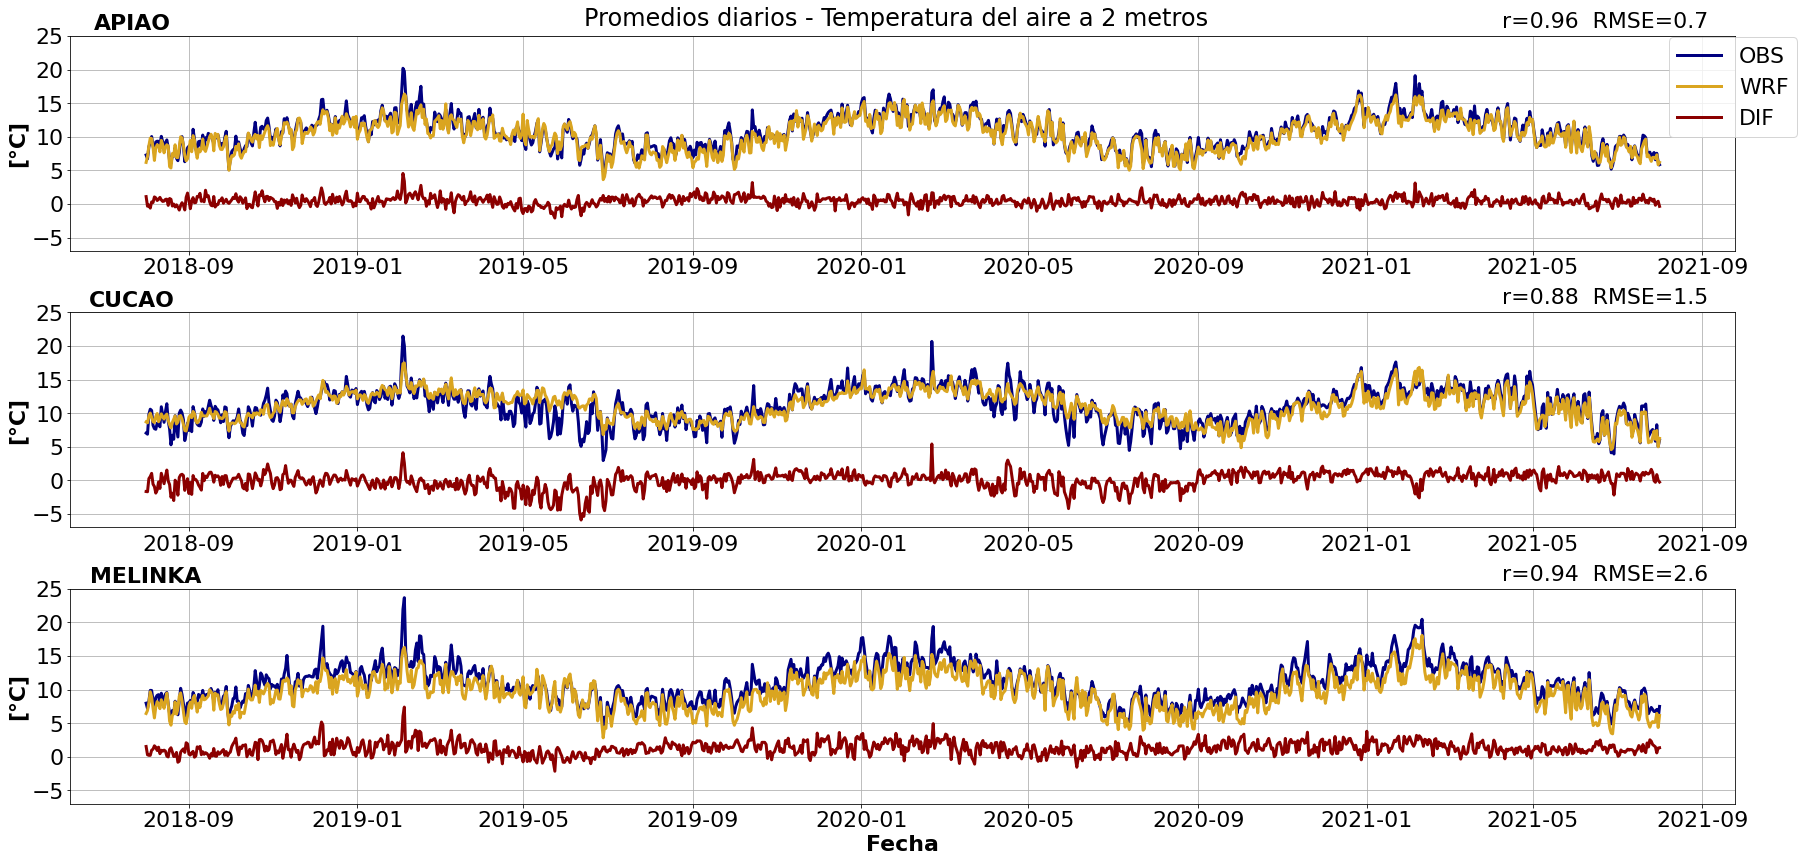

In [5]:
# SERIES DE TIEMPO PARA LOS PROMEDIOS DIARIOS
# ======================================================================================
fig, ax = plt.subplots(3,figsize=(25,12))
fig.suptitle('Promedios diarios - Temperatura del aire a 2 metros',x=0.5,y=0.994,fontsize=24)
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22) 
# APIAO
ax[0].plot(time,APIAO_diario["Mean"],color='navy',linewidth=3,label='OBS') #Observado
ax[0].plot(time,APIAO_MeanWRF,color='goldenrod',linewidth=3,label='WRF') #Simulado 
ax[0].plot(time,APIAO_diario["Mean"]-APIAO_diario["Mean_WRF"],color='darkred',linewidth=3,label='DIF') #Diferencia
ax[0].set_ylabel('[°C]', fontsize=22, weight='bold')
ax[0].set_ylim(-7,25)
ax[0].yaxis.set_major_locator(loc)
ax[0].yaxis.set_minor_locator(loc)
ax[0].set_title('APIAO',fontsize=22,x=0.037, y=1, weight='bold')
ax[0].grid(True)
ax[0].annotate("r=0.96  RMSE=0.7", xy=(0.86, 1.04), xycoords=ax[0].transAxes,fontsize=22)
ax[0].legend(fontsize=22,loc='upper right',bbox_to_anchor=(1.044, 1.045))
# CUCAO
ax[1].plot(time,CUCAO_diario["Mean"],color='navy',linewidth=3) #Observado
ax[1].plot(time,CUCAO_diario["Mean_WRF"],color='goldenrod',linewidth=3) #Simulado 
ax[1].plot(time,CUCAO_diario["Mean"]-CUCAO_diario["Mean_WRF"],color='darkred',linewidth=3) #Diferencia
ax[1].set_ylabel('[°C]', fontsize = 22, weight='bold')
ax[1].set_ylim(-7,25)
ax[1].yaxis.set_major_locator(loc)
ax[1].set_title('CUCAO',fontsize=22,x=0.037, y=1, weight='bold')
ax[1].grid(True)
ax[1].annotate("r=0.88  RMSE=1.5", xy=(0.86, 1.04), xycoords=ax[1].transAxes,fontsize=22)
# MELINKA
ax[2].plot(time,MELINKA_diario["Mean"],color='navy',linewidth=3) #Observado
ax[2].plot(time,MELINKA_diario["Mean_WRF"],color='goldenrod',linewidth=3) #Simulado 
ax[2].plot(time,MELINKA_diario["Mean"]-MELINKA_diario["Mean_WRF"],color='darkred',linewidth=3) #Diferencia
ax[2].set_xlabel('Fecha', fontsize = 22, weight='bold')
ax[2].set_ylabel('[°C]', fontsize = 22, weight='bold')
ax[2].set_ylim(-7,25)
ax[2].yaxis.set_major_locator(loc)
ax[2].set_title('MELINKA',fontsize=22,x=0.045, y=1, weight='bold')
ax[2].grid(True)
ax[2].annotate("r=0.94  RMSE=2.6", xy=(0.86, 1.04), xycoords=ax[2].transAxes,fontsize=22)
fig.tight_layout()
plt.savefig("T2_mean.png")

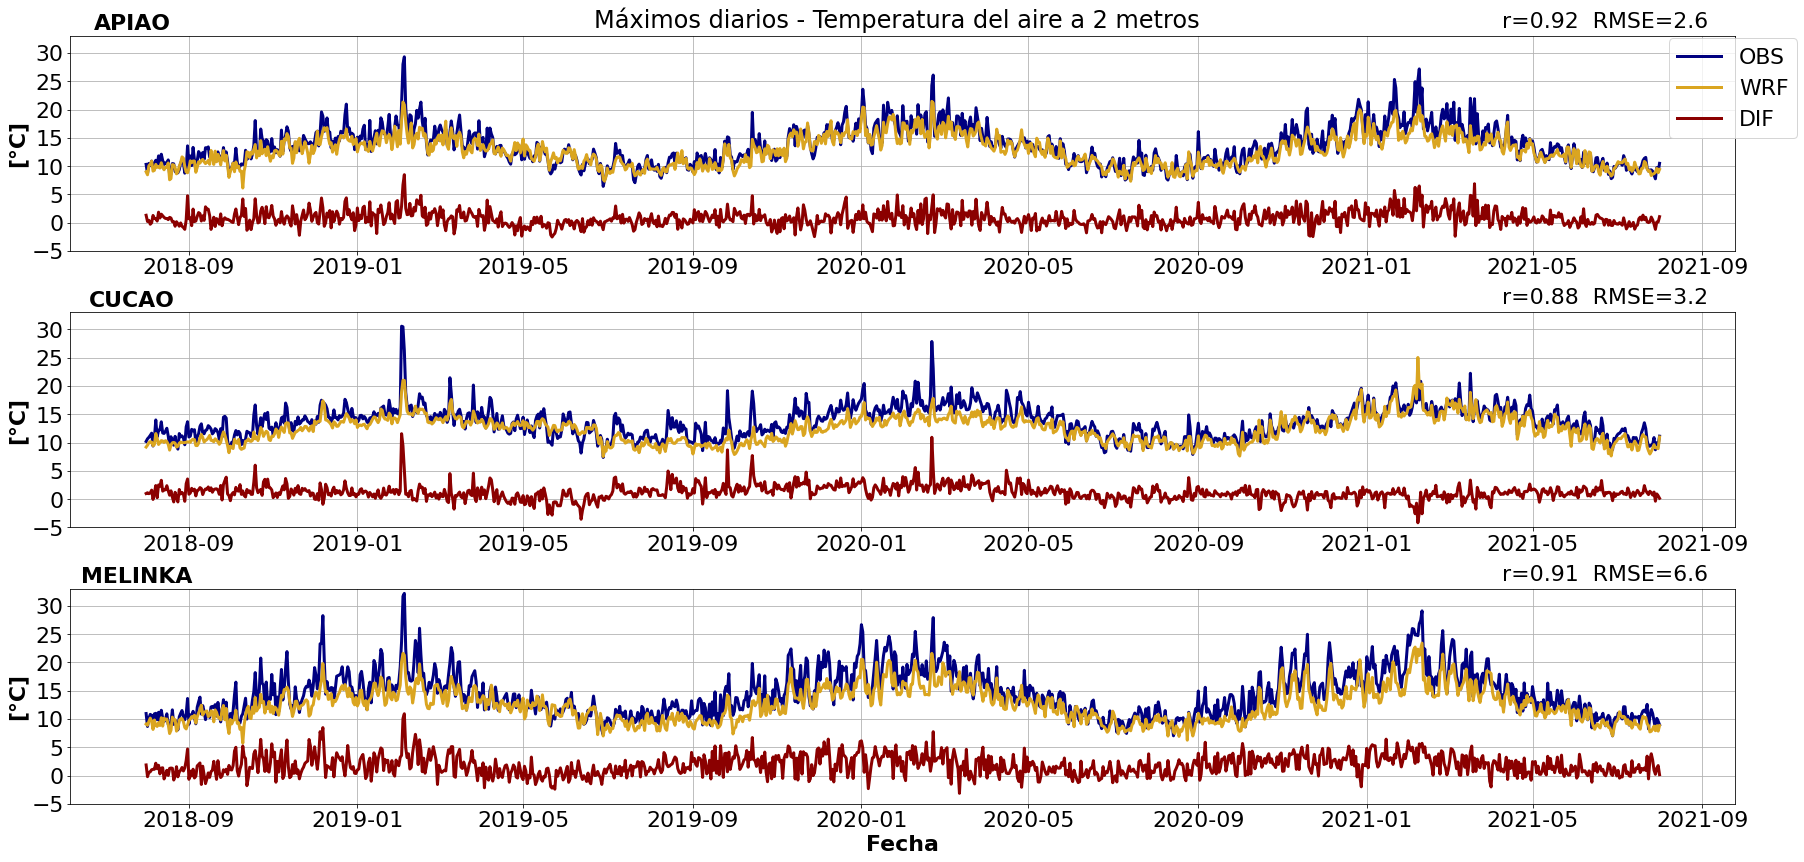

In [6]:
# SERIES DE TIEMPO PARA LOS MÁXIMOS DIARIOS
# ======================================================================================
fig, ax = plt.subplots(3,figsize=(25,12))
fig.suptitle('Máximos diarios - Temperatura del aire a 2 metros',x=0.5,y=0.994,fontsize=24)
# APIAO
ax[0].plot(time,APIAO_diario["Max"],color='navy',linewidth=3,label='OBS')
ax[0].plot(time,APIAO_diario["Max_WRF"],color='goldenrod',linewidth=3,label='WRF')
ax[0].plot(time,APIAO_diario["Max"]-APIAO_diario["Max_WRF"],color='darkred',linewidth=3,label='DIF')
ax[0].set_ylabel('[°C]', fontsize=22, weight='bold')
ax[0].set_ylim(-5,33)
ax[0].yaxis.set_major_locator(loc)
ax[0].set_title('APIAO',fontsize=22,x=0.037, y=1, weight='bold')
ax[0].grid(True)
ax[0].annotate("r=0.92  RMSE=2.6", xy=(0.86, 1.04), xycoords=ax[0].transAxes,fontsize=22)
ax[0].legend(fontsize=22,loc='upper right',bbox_to_anchor=(1.044, 1.04))
# CUCAO
ax[1].plot(time,CUCAO_diario["Max"],color='navy',linewidth=3)
ax[1].plot(time,CUCAO_diario["Max_WRF"],color='goldenrod',linewidth=3)
ax[1].plot(time,CUCAO_diario["Max"]-CUCAO_diario["Max_WRF"],color='darkred',linewidth=3)
ax[1].set_ylabel('[°C]', fontsize = 22, weight='bold')
ax[1].set_ylim(-5,33)
ax[1].yaxis.set_major_locator(loc)
ax[1].set_title('CUCAO',fontsize=22,x=0.037, y=1, weight='bold')
ax[1].grid(True)
ax[1].annotate("r=0.88  RMSE=3.2", xy=(0.86, 1.04), xycoords=ax[1].transAxes,fontsize=22)
# MELINKA
ax[2].plot(time,MELINKA_diario["Max"],color='navy',linewidth=3)
ax[2].plot(time,MELINKA_diario["Max_WRF"],color='goldenrod',linewidth=3)
ax[2].plot(time,MELINKA_diario["Max"]-MELINKA_diario["Max_WRF"],color='darkred',linewidth=3)
ax[2].set_xlabel('Fecha', fontsize = 22, weight='bold')
ax[2].set_ylabel('[°C]', fontsize = 22, weight='bold')
ax[2].set_ylim(-5,33)
ax[2].yaxis.set_major_locator(loc)
ax[2].set_title('MELINKA',fontsize=22,x=0.04, y=1, weight='bold')
ax[2].grid(True)
ax[2].annotate("r=0.91  RMSE=6.6", xy=(0.86, 1.04), xycoords=ax[2].transAxes,fontsize=22)
fig.tight_layout()
plt.savefig("T2_max.png")

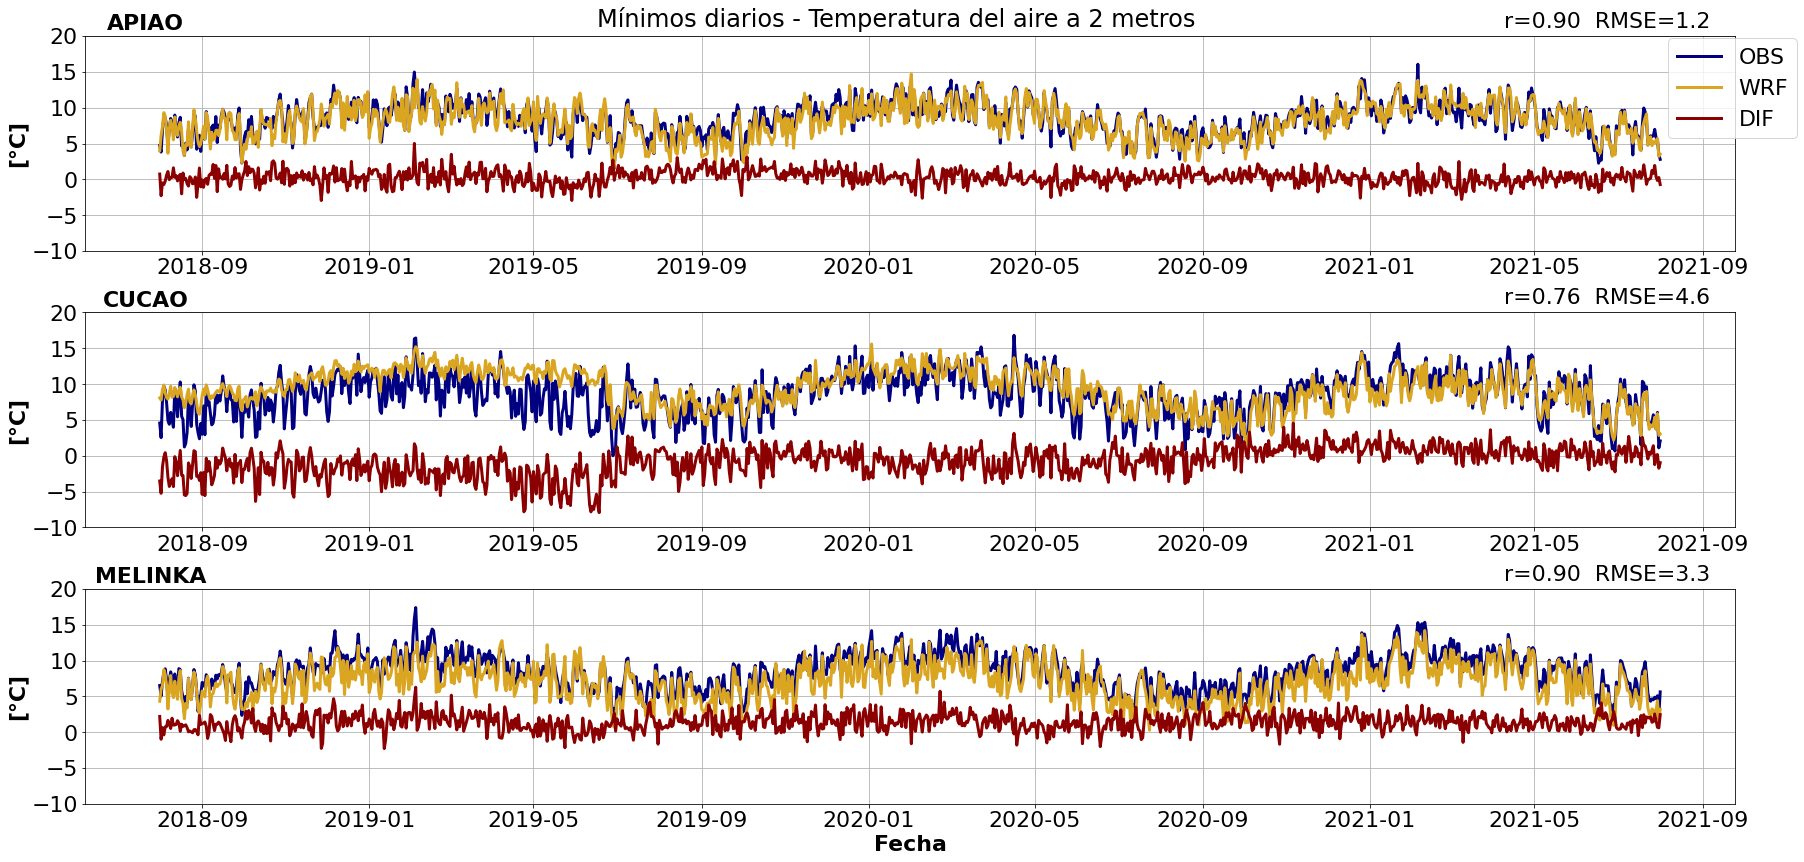

In [7]:
# SERIES DE TIEMPO PARA LOS MÍNIMOS DIARIOS
# ======================================================================================
fig, ax = plt.subplots(3,figsize=(25,12))
fig.suptitle('Mínimos diarios - Temperatura del aire a 2 metros',x=0.5,y=0.994,fontsize=24)
# APIAO
ax[0].plot(time,APIAO_diario["Min"],color='navy',linewidth=3,label='OBS') # Observado 
ax[0].plot(time,APIAO_diario["Min_WRF"],color='goldenrod',linewidth=3,label='WRF') # Simulado 
ax[0].plot(time,APIAO_diario["Min"]-APIAO_diario["Min_WRF"],color='darkred',linewidth=3,label='DIF') # Diferencia
ax[0].set_ylabel('[°C]', fontsize=22, weight='bold')
ax[0].set_ylim(-10,20)
ax[0].yaxis.set_major_locator(loc)
ax[0].set_title('APIAO',fontsize=22,x=0.037, y=1, weight='bold')
ax[0].grid(True)
ax[0].annotate("r=0.90  RMSE=1.2", xy=(0.86, 1.04), xycoords=ax[0].transAxes,fontsize=22)
ax[0].legend(fontsize=22,loc='upper right',bbox_to_anchor=(1.044, 1.04))
# CUCAO
ax[1].plot(time,CUCAO_diario["Min"],color='navy',linewidth=3) # Observado 
ax[1].plot(time,CUCAO_diario["Min_WRF"],color='goldenrod',linewidth=3) # Simulado 
ax[1].plot(time,CUCAO_diario["Min"]-CUCAO_diario["Min_WRF"],color='darkred',linewidth=3) # Diferencia
ax[1].set_ylabel('[°C]', fontsize = 22, weight='bold')
ax[1].set_ylim(-10,20)
ax[1].yaxis.set_major_locator(loc)
ax[1].set_title('CUCAO',fontsize=22,x=0.037, y=1, weight='bold')
ax[1].annotate("r=0.76  RMSE=4.6", xy=(0.86, 1.04), xycoords=ax[1].transAxes,fontsize=22)
ax[1].grid(True)
# MELINKA
ax[2].plot(time,MELINKA_diario["Min"],color='navy',linewidth=3) # Observado 
ax[2].plot(time,MELINKA_diario["Min_WRF"],color='goldenrod',linewidth=3) # Simulado
ax[2].plot(time,MELINKA_diario["Min"]-MELINKA_diario["Min_WRF"],color='darkred',linewidth=3) # Diferencia
ax[2].set_xlabel('Fecha', fontsize = 22, weight='bold')
ax[2].set_ylabel('[°C]', fontsize = 22, weight='bold')
ax[2].set_ylim(-10,20)
ax[2].yaxis.set_major_locator(loc)
ax[2].set_title('MELINKA',fontsize=22,x=0.04, y=1, weight='bold')
ax[2].annotate("r=0.90  RMSE=3.3", xy=(0.86, 1.04), xycoords=ax[2].transAxes,fontsize=22)
ax[2].grid(True)
fig.tight_layout()
plt.savefig("T2_min.png")

>  ***DIAGRAMAS DE DISPERSIÓN Y REGRESIÓN LINEAL***
















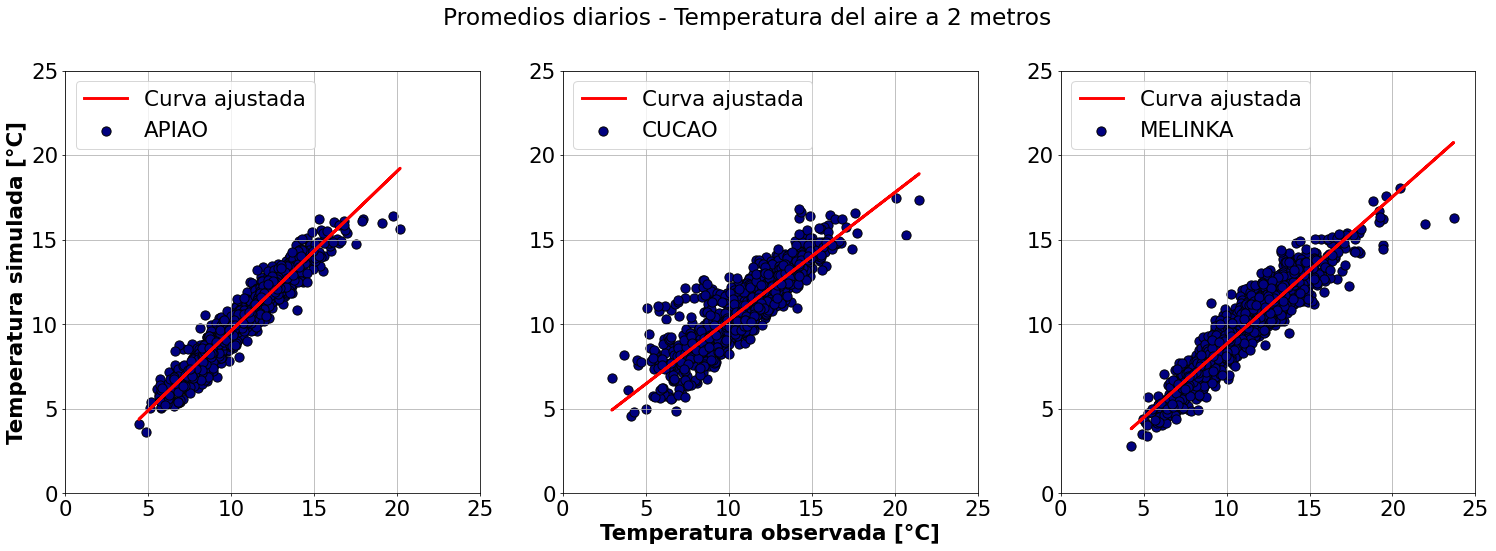

In [8]:
# PROMEDIO DIARIO
# ======================================================================================
# REGRESIÓN LINEAL PARA OBTENER CURVA AJUSTADA 
APIAO_Mean = APIAO_diario['Mean'].values.reshape(-1,1)
APIAO_MeanWRF = APIAO_diario['Mean_WRF'].values.reshape(-1,1)
linear_regressor = LinearRegression()
linear_regressor.fit(APIAO_Mean, APIAO_MeanWRF)
APIAO_MeanWRF_pred = linear_regressor.predict(APIAO_Mean)
CUCAO_Mean = CUCAO_diario['Mean'].values.reshape(-1,1)
CUCAO_MeanWRF = CUCAO_diario['Mean_WRF'].values.reshape(-1,1)
linear_regressor = LinearRegression()
linear_regressor.fit(CUCAO_Mean, CUCAO_MeanWRF)
CUCAO_MeanWRF_pred = linear_regressor.predict(CUCAO_Mean)
MELINKA_Mean = MELINKA_diario['Mean'].values.reshape(-1,1)
MELINKA_MeanWRF = MELINKA_diario['Mean_WRF'].values.reshape(-1,1)
linear_regressor = LinearRegression()
linear_regressor.fit(MELINKA_Mean, MELINKA_MeanWRF)
MELINKA_MeanWRF_pred = linear_regressor.predict(MELINKA_Mean)

# PLOTEAMOS 
fig, ax = plt.subplots(1,3,figsize=(26,8),dpi=70)
fig.suptitle('Promedios diarios - Temperatura del aire a 2 metros',x=0.5,y=0.994,fontsize=24)
# APIAO
ax[0].scatter(APIAO_diario["Mean"], APIAO_diario["Mean_WRF"], s=90, color='navy', edgecolor='k',label='APIAO'); # Observado vs simulado
ax[0].plot(APIAO_Mean, APIAO_MeanWRF_pred, color='red',label='Curva ajustada',linewidth=3) # Curva ajustada
ax[0].set_ylabel('Temperatura simulada [°C]', fontsize = 22, weight='bold')
ax[0].legend(fontsize=22,loc='upper left')
ax[0].yaxis.set_major_locator(loc)
ax[0].set_xlim(0,25)
ax[0].set_ylim(0,25)
ax[0].grid(True)
# CUCAO
ax[1].scatter(CUCAO_diario["Mean"], CUCAO_diario["Mean_WRF"], s=90, color='navy', edgecolor='k',label='CUCAO'); # Observado vs simulado
ax[1].plot(CUCAO_Mean, CUCAO_MeanWRF_pred, color='red',label='Curva ajustada',linewidth=3) # Curva ajustada
ax[1].set_xlabel('Temperatura observada [°C]', fontsize = 22, weight='bold')
ax[1].legend(fontsize=22,loc='upper left')
ax[1].yaxis.set_major_locator(loc)
ax[1].set_xlim(0,25)
ax[1].set_ylim(0,25)
ax[1].grid(True)
# MELINKA
ax[2].scatter(MELINKA_diario["Mean"], MELINKA_diario["Mean_WRF"], s=90, color='navy', edgecolor='k',label='MELINKA'); # Observado vs simulado
ax[2].plot(MELINKA_Mean, MELINKA_MeanWRF_pred, color='red',label='Curva ajustada',linewidth=3) # Curva ajustada
ax[2].legend(fontsize=22,loc='upper left')
ax[2].yaxis.set_major_locator(loc)
ax[2].set_xlim(0,25)
ax[2].set_ylim(0,25)
ax[2].grid(True)
plt.savefig("scatterplot_mean.png")

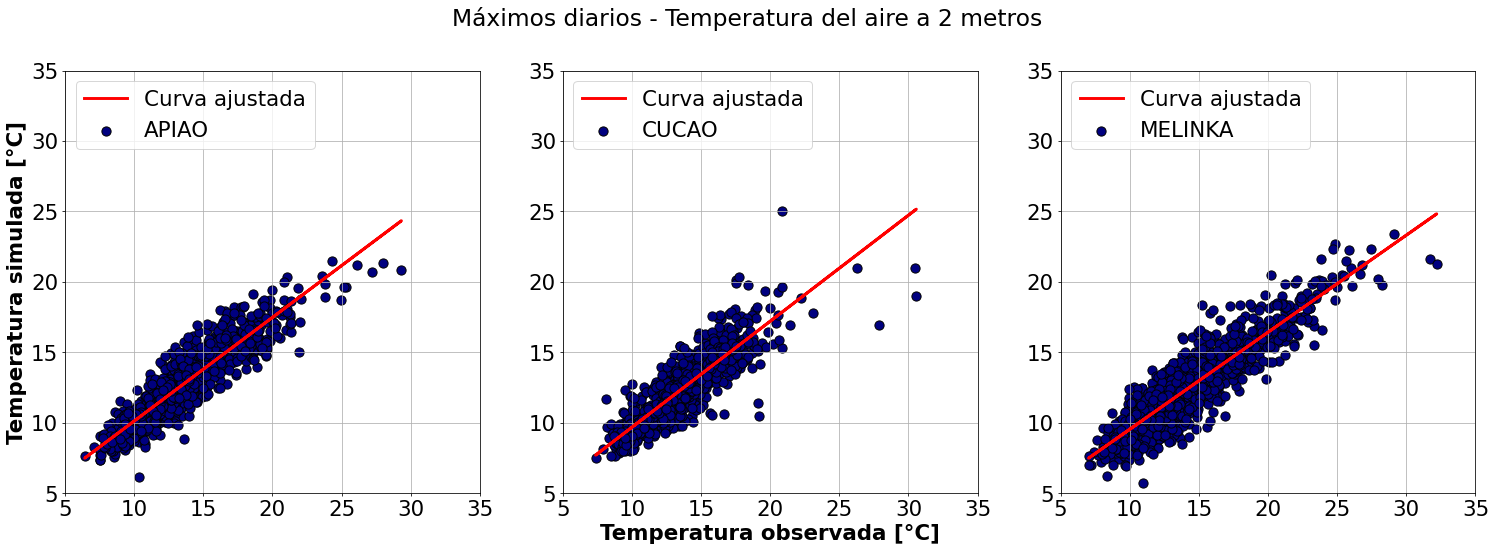

In [9]:
# MÁXIMO DIARIO
# ======================================================================================
# REGRESIÓN LINEAL PARA OBTENER CURVA AJUSTADA 
APIAO_Max = APIAO_diario['Max'].values.reshape(-1,1)
APIAO_MaxWRF = APIAO_diario['Max_WRF'].values.reshape(-1,1)
linear_regressor = LinearRegression()
linear_regressor.fit(APIAO_Max, APIAO_MaxWRF)
APIAO_MaxWRF_pred = linear_regressor.predict(APIAO_Max)
CUCAO_Max = CUCAO_diario['Max'].values.reshape(-1,1)
CUCAO_MaxWRF = CUCAO_diario['Max_WRF'].values.reshape(-1,1)
linear_regressor = LinearRegression()
linear_regressor.fit(CUCAO_Max, CUCAO_MaxWRF)
CUCAO_MaxWRF_pred = linear_regressor.predict(CUCAO_Max)
MELINKA_Max = MELINKA_diario['Max'].values.reshape(-1,1)
MELINKA_MaxWRF = MELINKA_diario['Max_WRF'].values.reshape(-1,1)
linear_regressor = LinearRegression()
linear_regressor.fit(MELINKA_Max, MELINKA_MaxWRF)
MELINKA_MaxWRF_pred = linear_regressor.predict(MELINKA_Max)

#PLOTEAMOS 
fig, ax = plt.subplots(1,3,figsize=(26,8),dpi=70)
fig.suptitle('Máximos diarios - Temperatura del aire a 2 metros',x=0.5,y=0.994,fontsize=24)
# APIAO
ax[0].scatter(APIAO_diario["Max"], APIAO_diario["Max_WRF"], s=90, color='navy', edgecolor='k',label='APIAO'); # Observado vs simulado
ax[0].plot(APIAO_Max, APIAO_MaxWRF_pred, color='red',label='Curva ajustada',linewidth=3) # Curva ajustada
ax[0].set_ylabel('Temperatura simulada [°C]', fontsize = 22, weight='bold')
ax[0].legend(fontsize=22,loc='upper left')
ax[0].yaxis.set_major_locator(loc)
ax[0].set_xlim(5,35)
ax[0].set_ylim(5,35)
ax[0].grid(True)
# CUCAO
ax[1].scatter(CUCAO_diario["Max"], CUCAO_diario["Max_WRF"], s=90, color='navy', edgecolor='k',label='CUCAO'); # Observado vs simulado
ax[1].plot(CUCAO_Max, CUCAO_MaxWRF_pred, color='red',label='Curva ajustada',linewidth=3) # Curva ajustada
ax[1].set_xlabel('Temperatura observada [°C]', fontsize = 22, weight='bold')
ax[1].legend(fontsize=22,loc='upper left')
ax[1].yaxis.set_major_locator(loc)
ax[1].set_xlim(5,35)
ax[1].set_ylim(5,35)
ax[1].grid(True)
# MELINKA
ax[2].scatter(MELINKA_diario["Max"], MELINKA_diario["Max_WRF"], s=90, color='navy', edgecolor='k',label='MELINKA'); # Observado vs simulado
ax[2].plot(MELINKA_Max, MELINKA_MaxWRF_pred, color='red',label='Curva ajustada',linewidth=3) # Curva ajustada
ax[2].legend(fontsize=22,loc='upper left')
ax[2].yaxis.set_major_locator(loc)
ax[2].set_xlim(5,35)
ax[2].set_ylim(5,35)
ax[2].grid(True)
plt.savefig("scatterplot_max.png")

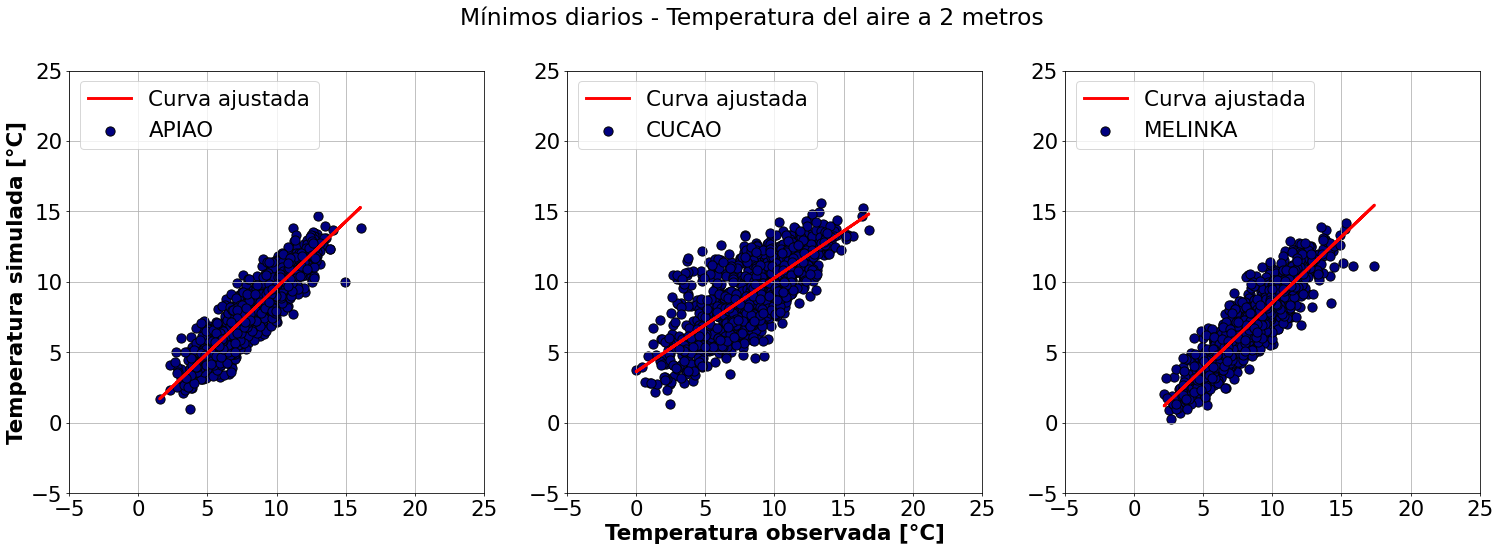

In [10]:
# MÍNIMO DIARIO
# ======================================================================================
# REGRESIÓN LINEAL PARA OBTENER CURVA AJUSTADA 
APIAO_Min = APIAO_diario['Min'].values.reshape(-1,1)
APIAO_MinWRF = APIAO_diario['Min_WRF'].values.reshape(-1,1)
linear_regressor = LinearRegression()
linear_regressor.fit(APIAO_Min, APIAO_MinWRF)
APIAO_MinWRF_pred = linear_regressor.predict(APIAO_Min)
CUCAO_Min = CUCAO_diario['Min'].values.reshape(-1,1)
CUCAO_MinWRF = CUCAO_diario['Min_WRF'].values.reshape(-1,1)
linear_regressor = LinearRegression()
linear_regressor.fit(CUCAO_Min, CUCAO_MinWRF)
CUCAO_MinWRF_pred = linear_regressor.predict(CUCAO_Min)
MELINKA_Min = MELINKA_diario['Min'].values.reshape(-1,1)
MELINKA_MinWRF = MELINKA_diario['Min_WRF'].values.reshape(-1,1)
linear_regressor = LinearRegression()
linear_regressor.fit(MELINKA_Min, MELINKA_MinWRF)
MELINKA_MinWRF_pred = linear_regressor.predict(MELINKA_Min)

#PLOTEAMOS 
fig, ax = plt.subplots(1,3,figsize=(26,8),dpi=70)
fig.suptitle('Mínimos diarios - Temperatura del aire a 2 metros',x=0.5,y=0.994,fontsize=24)
# APIAO
ax[0].scatter(APIAO_diario["Min"], APIAO_diario["Min_WRF"], s=90, color='navy', edgecolor='k',label='APIAO'); # Observado vs simulado
ax[0].plot(APIAO_Min, APIAO_MinWRF_pred, color='red',label='Curva ajustada',linewidth=3) # Curva ajustada
ax[0].set_ylabel('Temperatura simulada [°C]', fontsize = 22, weight='bold')
ax[0].legend(fontsize=22,loc='upper left')
ax[0].yaxis.set_major_locator(loc)
ax[0].set_xlim(-5,25)
ax[0].set_ylim(-5,25)
ax[0].grid(True)
# CUCAO
ax[1].scatter(CUCAO_diario["Min"], CUCAO_diario["Min_WRF"], s=90, color='navy', edgecolor='k',label='CUCAO'); # Observado vs simulado
ax[1].plot(CUCAO_Min, CUCAO_MinWRF_pred, color='red',label='Curva ajustada',linewidth=3) # Curva ajustada
ax[1].set_xlabel('Temperatura observada [°C]', fontsize = 22, weight='bold')
ax[1].legend(fontsize=22,loc='upper left')
ax[1].yaxis.set_major_locator(loc)
ax[1].set_xlim(-5,25)
ax[1].set_ylim(-5,25)
ax[1].grid(True)
# MELINKA
ax[2].scatter(MELINKA_diario["Min"], MELINKA_diario["Min_WRF"], s=90, color='navy', edgecolor='k',label='MELINKA'); # Observado vs simulado
ax[2].plot(MELINKA_Min, MELINKA_MinWRF_pred, color='red',label='Curva ajustada',linewidth=3) # Curva ajustada
ax[2].legend(fontsize=22,loc='upper left')
ax[2].yaxis.set_major_locator(loc)
ax[2].set_xlim(-5,25)
ax[2].set_ylim(-5,25)
ax[2].grid(True)
plt.savefig("scatterplot_min.png")